In [1]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rpy2
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
numpy2ri.activate()
pandas2ri.activate()

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import pims
from tqdm.auto import tqdm

from lib import detection
from lib import analysis

# Classifier V3.0: A New Hope??

We have a whole new set of cells. Let's sample puffs from each of those cells to build a training dataset. Ideally, I will have sampled randomly and have an equal number of cells from each condition. In reality, here's what condition_checker tells me:

```
condition_checker.py ~/UM\ Drive/OPP/OPP_scramble.log 0IYVHRNA.tif 19CC75ZU.tif 2TZWB6CN.tif 3W70AV4V.tif 3WE2GUYC.tif 5FWR8G3N.tif 5RTVNBXU.tif 6SG3YVW7.tif 7C4SV01F.tif 7XFW332I.tif 7XGJBQQ3.tif 7YFIHF8P.tif 8C92MS0M.tif 9VEA7WGA.tif
2 B2 cells, 6 MOR cells, 6 TfR Cells
```

So that's not...GREAT. But it's a start for a classifier. So, how do we do this?

## Sample Selection

Let's evaluate each of the cells that have been scored so far and find out the frequency of puffs and total number of puffs in those cells:

In [2]:
basedir = '/Volumes/Coatamer/Users/weinberz/UM Drive/OPP'
files = os.listdir(basedir)
tifs = [tif for tif in files if 'tif' in tif]
xmls = [xml for xml in files if 'xml' in xml]
movie_info = {}
for tif in tifs:
    movie_name = tif.split('.')[0]
    matches = [xml for xml in xmls if movie_name in xml]
    if matches:
        movie_info[movie_name] = {'tif' : tif,
                                  'xml' : matches[0]}

In [4]:
for movie in movie_info:
    events = pd.read_csv('data/'+movie+'.tif_events.csv',
                         usecols = [1,2,3,4], 
                         names = ['frame','x','y','particle'],
                         header=0)
#                          dtype = {'frame': np.int16, 'x' : np.int8, 'y' : np.int8, 'particle' : np.int32})
    marker_locs = puff_lib.import_xml_data(basedir + os.sep + movie_info[movie]['xml'])
    puff_ids = np.array([puff_lib.filter_df(events, m, 5) for m in marker_locs])
    print('%d puffs in %d events (%.4f puff rate)' % (len(np.unique(puff_ids[puff_ids>0])),
                                                      len(np.unique(events['particle'])),
                                                      (len(np.unique(puff_ids[puff_ids>0]))/len(np.unique(events['particle'])))))

38 puffs in 28102 events (0.0014 puff rate)
396 puffs in 44767 events (0.0088 puff rate)
61 puffs in 22464 events (0.0027 puff rate)
64 puffs in 39864 events (0.0016 puff rate)
493 puffs in 37621 events (0.0131 puff rate)
62 puffs in 39735 events (0.0016 puff rate)
490 puffs in 38419 events (0.0128 puff rate)
70 puffs in 25483 events (0.0027 puff rate)
107 puffs in 32152 events (0.0033 puff rate)
39 puffs in 33363 events (0.0012 puff rate)
518 puffs in 38734 events (0.0134 puff rate)
32 puffs in 22790 events (0.0014 puff rate)
240 puffs in 28320 events (0.0085 puff rate)
265 puffs in 33818 events (0.0078 puff rate)
74 puffs in 28404 events (0.0026 puff rate)
16 puffs in 16953 events (0.0009 puff rate)
642 puffs in 46411 events (0.0138 puff rate)
201 puffs in 27119 events (0.0074 puff rate)


That's a large range :/. Let's go through each, pull enough events to contain at least 16 puffs (the minimum of the above), while maintaining the overall distribution of puffs-to-non-puffs in each movie.

In [5]:
# labeled_sample = pd.read_csv('all_sample_features.csv', index_col=0)

###
# Code for generating samples
# Note: original generation reset at 10th movie - all subsequent movies started with
# a fresh random seed
###

np.random.seed(237)
num_puffs_to_sample = 74

for movie in list(movie_info.keys()):
    movie_file = movie_info[movie]['tif']
    movie_tif = pims.TiffStack(basedir + os.sep + movie_file)

    events = pd.read_csv('data/'+movie+'.tif_events.csv',
                         usecols = [1,2,3,4], 
                         names = ['frame','x','y','particle'],
                         header=0)
    marker_locs = puff_lib.import_xml_data(basedir + os.sep + movie_info[movie]['xml'])

    puff_ids = np.unique([puff_lib.filter_df(events, m, 5) for m in marker_locs])
    puff_ids = puff_ids[puff_ids>0]
    nonpuff_ids = np.array([idx for idx in np.unique(events['particle']) if idx not in puff_ids])
    num_puffs = len(np.unique(puff_ids))
    num_events = len(np.unique(events['particle']))
    puff_freq = num_puffs/num_events

    if num_puffs <= num_puffs_to_sample:
        sample_ids = events['particle'].values
        puff_ids_to_sample = puff_ids
        nonpuff_ids_to_sample = np.setdiff1d(sample_ids, puff_ids_to_sample)
        sample_events = events
    else:
        puff_ids_to_sample = np.random.choice(puff_ids,num_puffs_to_sample,replace=False)
        nonpuff_ids_to_sample = np.random.choice(nonpuff_ids,int(num_puffs_to_sample/puff_freq), replace=False)
        sample_ids = np.hstack([puff_ids_to_sample, nonpuff_ids_to_sample])
        sample_events = events.loc[events['particle'].isin(sample_ids)]

    t_start = time.time()
    print("Getting intensities for %s... " % movie, end='')
    sample_intensities = puff_lib.intensity_grid(movie_tif, sample_events, delta=4)
    t_end = time.time() - t_start
    print("Finished (%d seconds)" % t_end)

    sample_events.loc[:, 'puff'] = sample_events['particle'].isin(puff_ids_to_sample).astype(int)
    sample_intensities.loc[:, 'puff'] = sample_intensities['particle'].isin(puff_ids_to_sample).astype(int)

    sample_events.to_csv(movie + "_sample_events.csv")
    sample_intensities.to_csv(movie + "_sample_intensities.csv")

Getting intensities for 0IYVHRNA... Finished (48 seconds)
Getting intensities for 19CC75ZU... Finished (22 seconds)


/Volumes/Coatamer/Users/weinberz/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Getting intensities for 2TZWB6CN... Finished (27 seconds)
Getting intensities for 3W70AV4V... Finished (36 seconds)
Getting intensities for 3WE2GUYC... Finished (16 seconds)
Getting intensities for 42GSRFR0... Finished (37 seconds)
Getting intensities for 53BFW81Q... Finished (16 seconds)
Getting intensities for 56CCWWJI... Finished (22 seconds)
Getting intensities for 5FWR8G3N... Finished (23 seconds)
Getting intensities for 5RTVNBXU... Finished (29 seconds)
Getting intensities for 6SG3YVW7... Finished (19 seconds)
Getting intensities for 79NWKD4H... Finished (13 seconds)
Getting intensities for 7C4SV01F... Finished (16 seconds)
Getting intensities for 7XFW332I... Finished (18 seconds)
Getting intensities for 7XGJBQQ3... Finished (27 seconds)
Getting intensities for 7YFIHF8P... Finished (17 seconds)
Getting intensities for 8C92MS0M... Finished (16 seconds)
Getting intensities for 9VEA7WGA... Finished (18 seconds)


In [6]:
features_list = []
for movie in list(movie_info.keys()):
    sample_intensities = pd.read_csv(movie + "_sample_intensities.csv", index_col=0)
    puff_ids_to_sample = sample_intensities.loc[sample_intensities['puff']==1,'particle'].values
    t_start = time.time()
    print("Getting features for %s... " % movie, end='')
    get_features = rpy2.robjects.globalenv['get_features']
    sample_features = pandas2ri.ri2py_dataframe(get_features(sample_intensities))
    t_end = time.time() - t_start
    print("Finished (%d seconds)" % t_end)

    sample_features.loc[:, 'cell'] = movie
    sample_features.loc[:, 'puff'] = sample_features['particle'].isin(puff_ids_to_sample).astype(int)
    sample_features.to_csv(movie + "_sample_features.csv")
    
    features_list.append(sample_features)
    
labeled_sample = pd.concat(features_list, ignore_index=True)

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Getting features for 0IYVHRNA... 

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/py37/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Finished (1697 seconds)
Getting features for 19CC75ZU... Finished (736 seconds)
Getting features for 2TZWB6CN... Finished (1156 seconds)
Getting features for 3W70AV4V... Finished (2240 seconds)
Getting features for 3WE2GUYC... Finished (354 seconds)
Getting features for 42GSRFR0... Finished (2441 seconds)
Getting features for 53BFW81Q... Finished (362 seconds)
Getting features for 56CCWWJI... Finished (1183 seconds)
Getting features for 5FWR8G3N... Finished (1000 seconds)
Getting features for 5RTVNBXU... Finished (1842 seconds)
Getting features for 6SG3YVW7... Finished (475 seconds)
Getting features for 79NWKD4H... Finished (875 seconds)
Getting features for 7C4SV01F... Finished (366 seconds)
Getting features for 7XFW332I... Finished (648 seconds)
Getting features for 7XGJBQQ3... Finished (1444 seconds)
Getting features for 7YFIHF8P... Finished (1015 seconds)
Getting features for 8C92MS0M... Finished (430 seconds)
Getting features for 9VEA7WGA... Finished (526 seconds)


In [7]:
print('%d puffs in %d events (%.4f puff rate)' % (np.sum(labeled_sample['puff']),
                                                  np.shape(labeled_sample)[0],
                                                  (np.sum(labeled_sample['puff'])/np.shape(labeled_sample)[0])))

1122 puffs in 338913 events (0.0033 puff rate)


We have a very poorly enriched puff sample, but hopefully with ~1000 events we are at least approaching a point where our classifier can adequately capture unique aspects of our puffs.

## Classifier

With a puff sample detected, we can now generate a classifier trained on it. The following is the evaluated OOB sample on a calssifier train on all of the data

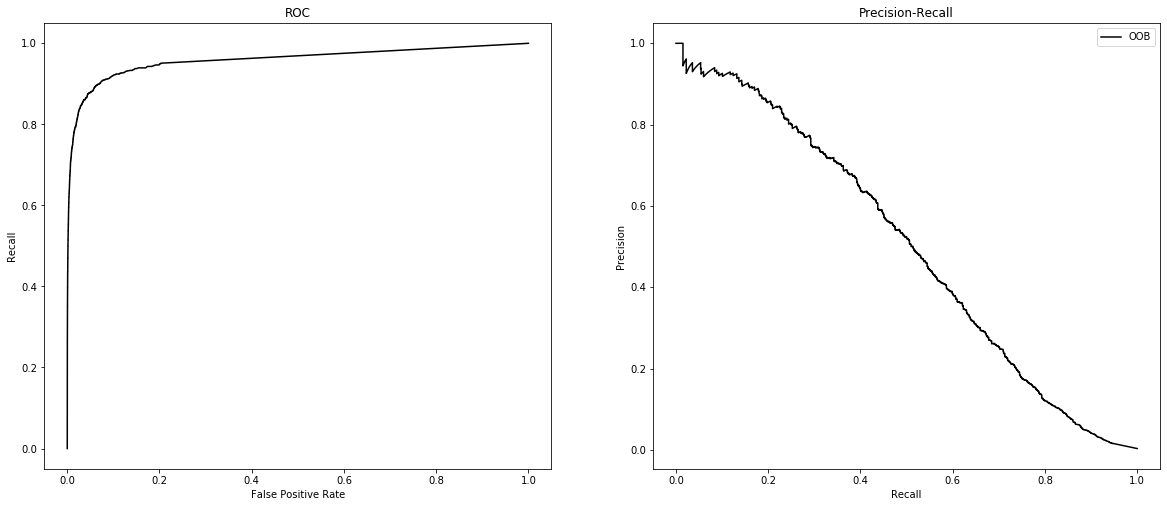

In [10]:
classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)

training_fields = ['conv_perim', 'conv_area',
                   'cc11', 'cc12', 'cc13',
                   'cc21', 'cc22', 'cc23',
                   'lifetime_s', 'deltaf', 'tau']

classifier.fit(labeled_sample[training_fields], labeled_sample['puff'])

plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
fpr, tpr , thresholds= roc_curve(labeled_sample['puff'], classifier.oob_decision_function_[:,1], pos_label = 1)
ax1.plot(fpr, tpr, label="OOB", color="k")
precision, recall, thresholds = precision_recall_curve(labeled_sample['puff'], classifier.oob_decision_function_[:,1],pos_label = 1)
ax2.plot(recall, precision, label="OOB", color="k")
plt.legend()

Distribution of predicted puffness for puffs and non-puffs:

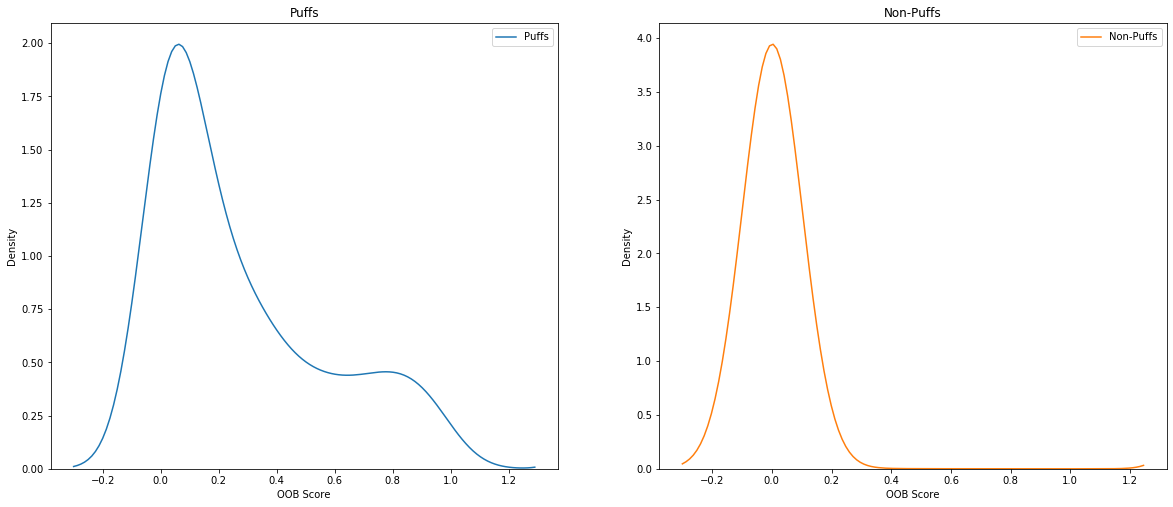

In [11]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('OOB Score')
ax1.set_ylabel('Density')
ax1.set_title('Puffs')
ax2 = plt.subplot(122)
ax2.set_xlabel('OOB Score')
ax2.set_ylabel('Density')
ax2.set_title('Non-Puffs')
sns.kdeplot(classifier.oob_decision_function_[labeled_sample['puff'] == 1, 1], label="Puffs", ax=ax1, bw=0.1)
sns.kdeplot(classifier.oob_decision_function_[labeled_sample['puff'] == 0, 1], label="Non-Puffs", ax=ax2, color="C1", bw=0.1)

Round-robin classifier suggests variable performance across cells and depending on which cells are in the dataset:

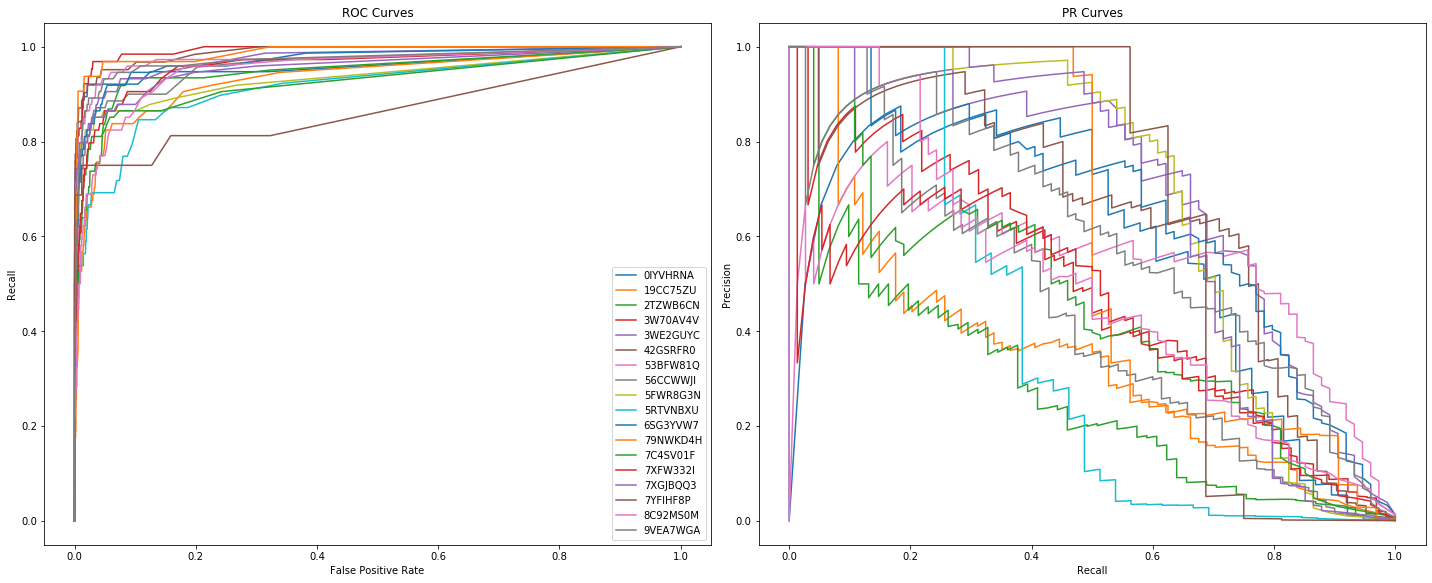

In [12]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC Curves')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves')

for cell in tqdm(np.unique(labeled_sample['cell'])):
    held_data = labeled_sample.loc[labeled_sample['cell'] == cell]
    train_data = labeled_sample.loc[labeled_sample['cell'] != cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['puff'])
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['puff'], probas_[:,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held_data['puff'], probas_[:,1],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
    labeled_sample.loc[labeled_sample['cell'] == cell, 'proba'] = probas_[:,1]
                             
ax1.legend()
plt.tight_layout()
plt.show()

In [28]:
np.shape(labeled_sample.loc[labeled_sample['lifetime_s'] > 0.2,'puff'])

(50298,)